# Home Loans: Customer Segmentation

## Introduction

Home loans are contracts that allow a borrower to borrow money from a lender, usually banks/ financial companies, to buy, build, or repair a house, apartment, or other property. It involves an interest rate as the cost of borrowing, and the loan can be paid over a period of 10, 15, or 30 years, depending on the contract terms. Thus, as this is a long-term commitment, lenders would want to be careful in accepting loan applications, rejecting those with a higher chance of default.

What is a default? It is when a borrower does not pay the lended fund/ stops paying sometime during the agreed loan term, hence resulting in a loss for the lender. So, what are the characteristics of a loan application having a high potential of default? And how do they differ from those that are not likely to default?

Today, we're going to look at this [dataset](https://www.kaggle.com/gavincanacam/home-loan-predictions) from kaggle, which contains information about 614 loan applications, and whether they should be accepted. We'll first clean and perform EDA on the dataset. Then, we're going to utilise k-means clustering, in hopes of identifying 'groups' or 'clusters' with characteristics leading to a high default rate.

### Importing the data

In [1]:
import pandas as pd
import numpy as np

Train = pd.read_csv('Train_Loan_Home.csv')
Train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


The dataset has 614 rows and 13 columns, with the following description.
- Loan_ID: ID of loan application.
- Gender: Gender of applicant.
- Married: Whether the applicant is married.
- Dependents: Number of applicant's dependents (1, 2, or 3+).
- Education: Whether the applicant is a graduate.
- Self_Employed: Whether the applicant is self employed.
- ApplicantIncome: Monthly income of applicant.
- CoapplicantIncome: Monthly income of coapplicant (0 if none).
- LoanAmount: Amount of loan (in thousands).
- Loan_Amount_Term: Period of loan (in months).
- Credit_History: Whether the applicant has borrowed money before and paid the sum (1 for yes, 0 for no).
- Property_Area: Area of property (Urban, Suburban, or Rural).
- Loan_Status: Y if accepted (good loans) and N if not accepted (bad loans).

Additionally, the columns are of these types

In [2]:
Train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Let's see if there are any missing values in the dataset.

In [3]:
print('Number of null values for each column in training data: ')
print(Train.isna().sum())

Number of null values for each column in training data: 
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Our data only has 614 rows, so we'll try to impute the missing values. But before that, let's do a few more checks on the dataset.

In [4]:
#Checking for duplicates
Unique_vals = ['Loan_ID']

for features in Unique_vals:
    Col = Train[features]
    Length = len(Col)
    Unique = len(set(Col))
    if (Length/Unique) == 1:
        print('Values in the column {} are unique. No duplicates found.\n'.format(features))
    else:
        s = Train[features].value_counts()
        print('Values in the column {} are not unique. Duplicates and frequencies:'.format(features))
        print(s.where(s>1).dropna())
        print('\n')

Values in the column Loan_ID are unique. No duplicates found.



There are no duplicates in the ID column, meaning all entries are unique.

In [5]:
#Looking at the number of values for categorical features
Categorical_vals = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for features in Categorical_vals:
    print('Values for column {}: '.format(features), set(Train[features]),', Length: ',len(set(Train[features])),'\n')


Values for column Gender:  {nan, 'Female', 'Male'} , Length:  3 

Values for column Married:  {nan, 'Yes', 'No'} , Length:  3 

Values for column Dependents:  {nan, '1', '2', '0', '3+'} , Length:  5 

Values for column Education:  {'Graduate', 'Not Graduate'} , Length:  2 

Values for column Self_Employed:  {nan, 'Yes', 'No'} , Length:  3 

Values for column Property_Area:  {'Urban', 'Rural', 'Semiurban'} , Length:  3 

Values for column Loan_Status:  {'N', 'Y'} , Length:  2 



In [6]:
Integer_vals = ['ApplicantIncome','CoapplicantIncome','LoanAmount', 
                'Loan_Amount_Term', 'Credit_History']

print('Summary for numerical features: \n', Train[Integer_vals].describe()) 

#Applicant and coapplicant income are monthly (exact values), while loan amount are in thousands. 
#loan amount term is in months

Summary for numerical features: 
        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


## Data cleaning

Now, let's start the data cleaning process. We'll first load another copy of the dataset, naming it Dummy_train. The reason for this will be clear in the next few steps.

In [7]:
Dummy_train = pd.read_csv('Train_Loan_Home.csv')

We'll then scale the numerical values, so they'll be in the range of 0 to 1.

In [8]:
Integer_vals = ['ApplicantIncome','CoapplicantIncome','LoanAmount', 
                'Loan_Amount_Term', 'Credit_History']

Dummy_train[Integer_vals] = (Dummy_train[Integer_vals] 
                             - Dummy_train[Integer_vals].min())/(Dummy_train[Integer_vals].max() -
                                                                            Dummy_train[Integer_vals].min())
Dummy_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,0.070489,0.000000,NaN,0.743590,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,0.054830,0.036192,0.172214,0.743590,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,0.035250,0.000000,0.082489,0.743590,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,0.030093,0.056592,0.160637,0.743590,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,0.072356,0.000000,0.191027,0.743590,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,0.034014,0.000000,0.089725,0.743590,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,0.048930,0.000000,0.044863,0.358974,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,0.097984,0.005760,0.353111,0.743590,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,0.091936,0.000000,0.257598,0.743590,1.0,Urban,Y


Then, we encode the categorical values.

In [9]:
Categorical_vals = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                    'Property_Area', 'Credit_History']

for features in Categorical_vals:
    Feature_dummies = pd.get_dummies(Dummy_train[features], prefix = features)
    Dummy_train = pd.concat([Dummy_train, Feature_dummies], axis = 1)
    Dummy_train.drop(features, axis = 1, inplace = True)

Dummy_train

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_0.0,Credit_History_1.0
0,LP001002,0.070489,0.000000,NaN,0.743590,Y,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
1,LP001003,0.054830,0.036192,0.172214,0.743590,N,0,1,0,1,...,0,1,0,1,0,1,0,0,0,1
2,LP001005,0.035250,0.000000,0.082489,0.743590,Y,0,1,0,1,...,0,1,0,0,1,0,0,1,0,1
3,LP001006,0.030093,0.056592,0.160637,0.743590,Y,0,1,0,1,...,0,0,1,1,0,0,0,1,0,1
4,LP001008,0.072356,0.000000,0.191027,0.743590,Y,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,0.034014,0.000000,0.089725,0.743590,Y,1,0,1,0,...,0,1,0,1,0,1,0,0,0,1
610,LP002979,0.048930,0.000000,0.044863,0.358974,Y,0,1,0,1,...,1,1,0,1,0,1,0,0,0,1
611,LP002983,0.097984,0.005760,0.353111,0.743590,Y,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1
612,LP002984,0.091936,0.000000,0.257598,0.743590,Y,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1


Finally, we store the target values (the loan status) in a seperate variable and remove them from the dataset.

In [10]:
Target = Train['Loan_Status']
Train.drop(['Loan_Status', 'Loan_ID'], axis = 1, inplace = True)
Dummy_train.drop(['Loan_Status', 'Loan_ID'], axis = 1, inplace = True)

In [11]:
Dummy_train.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_0.0,Credit_History_1.0
0,0.070489,0.000000,NaN,0.74359,0,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1
1,0.054830,0.036192,0.172214,0.74359,0,1,0,1,0,1,...,0,1,0,1,0,1,0,0,0,1
2,0.035250,0.000000,0.082489,0.74359,0,1,0,1,1,0,...,0,1,0,0,1,0,0,1,0,1
3,0.030093,0.056592,0.160637,0.74359,0,1,0,1,1,0,...,0,0,1,1,0,0,0,1,0,1
4,0.072356,0.000000,0.191027,0.74359,0,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1


### Missing Values

Let's start filling the missing values.

In [12]:
Train.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

We'll do this column by column. First, we'll go through the categorical values before filling the numerical ones. We'll start with the first column, gender.

In [13]:
Train['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

Since most applicant are male, we can either fill all the missing values as male, or fill them in such a way so that the proportion stays as above. Here, we go with the latter.

In [14]:
Train['Gender'].value_counts(normalize = True)
Train['Gender'] = Train['Gender'].fillna(pd.Series(np.random.choice(['Male', 'Female'], 
                                                                                    p=[0.813644, 0.186356], 
                                                                                    size = len(Train))))
#Gender column done

In [15]:
Train.isnull().sum()

Gender                0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

In [16]:
Train['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

For the column Married, we'll go with a different approach, which is to fill the missing values using similar entries. In fact, this will be the approach we'll be using for most of the other categorical columns. And this is where our Dummy_train data comes into play.

We'll first write a function to do this. The idea is that the function will find similar rows (based on the euclidian distance) to the missing entry, and from there, pick the closest 3. It will then get the majority value, and input it to the missing entry in the original dataset. 

In [17]:
import scipy.spatial

pd.options.mode.chained_assignment = None

def Fill_missing_cat_vals(feature):
    
    N_list = [val for val in Train[Train[feature].isna()].index]
    for i in N_list:
        df1 = Dummy_train.iloc[[i]] #Features are encoded, no exact name
        df2 = Dummy_train
        Ind_missing = i
        
        df2['dist'] = scipy.spatial.distance.cdist(df2, df1, metric = 'euclidean')
        
        Train['dist'] = [val for val in df2['dist']]
        Entry = Train[Train[feature].notnull()].sort_values('dist').iloc[:3]
        
        Which_ind = Entry[feature].value_counts().argmax()
        val = Entry[feature].value_counts().index[Which_ind]
        
        Train.drop('dist', axis = 1, inplace = True)
                 
        Train.at[Ind_missing, feature] = val
        
    print('Missing values for column {}: Done\n'.format(feature))
    print(Train.isna().sum())
    print('\n')

In [18]:
Fill_missing_cat_vals('Married')

Missing values for column Married: Done

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64




And just like that, we've handled the missing values for the column Married. Note that, however, in this process, we're making a strong assumption that similar rows will have similar characteristics. 

Now, let's take a look at the other columns.

In [19]:
for feature in ['Dependents', 'Self_Employed', 'Credit_History']:
    print(Train[feature].value_counts(), '\n')

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64 

No     500
Yes     82
Name: Self_Employed, dtype: int64 

1.0    475
0.0     89
Name: Credit_History, dtype: int64 



Let's do the same for these columns.

In [20]:
for features in ['Dependents', 'Self_Employed', 'Credit_History']:
    Fill_missing_cat_vals(features)

Missing values for column Dependents: Done

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64


Missing values for column Self_Employed: Done

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64


Missing values for column Credit_History: Done

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
dtype: int64




At this point, we've taken care of the missing values in the categorical columns. We now wish to do the same for the numerical ones. However, to do that, we would need to make some adjustments to the function we used before.

In [21]:
def Fill_missing_num_vals(feature):
    
    N_list = [val for val in Train[Train[feature].isna()].index]
    for i in N_list:
        df1 = Dummy_train.iloc[[i]]
        df2 = Dummy_train
        Ind_missing = i
        
        df2['dist'] = scipy.spatial.distance.cdist(df2, df1, metric = 'euclidean')
        
        Train['dist'] = [val for val in df2['dist']]
        Entry = Train[Train[feature].notnull()].sort_values('dist').iloc[:5]
        
        val = Entry[feature].median()
        
        Train.drop('dist', axis = 1, inplace = True)
                 
        Train.at[Ind_missing, feature] = val
        
    print('Missing values for column {}: Done\n'.format(feature))
    print(Train.isna().sum())
    print('\n')

Here, the idea is very similar to the Fill_missing_cat_vals we used previously. But, instead of taking 3 rows, we now take 5 rows, and from there, input the missing entry with the median of the 5 similar entries.

Let us do this for the 2 numerical columns with missing entries.

In [22]:
for features in ['LoanAmount', 'Loan_Amount_Term']:
    Fill_missing_num_vals(features)

Missing values for column LoanAmount: Done

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History        0
Property_Area         0
dtype: int64


Missing values for column Loan_Amount_Term: Done

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64




Now, we've taken care of the missing values and can move to the next part of our analysis.

## Exploratory Data Analysis

First, let's include the target variables again to our data.

In [23]:
Train['Loan_Status'] = [val for val in Target]
Train['Loan_Status'].replace({'Y': 1, 'N':0}, inplace = True)

In [24]:
Train.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


Now, let's perform some exploratory data analysis.

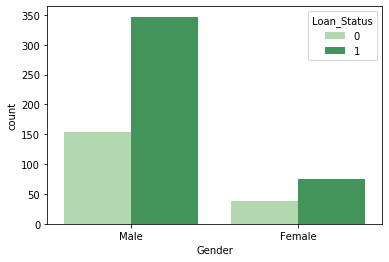

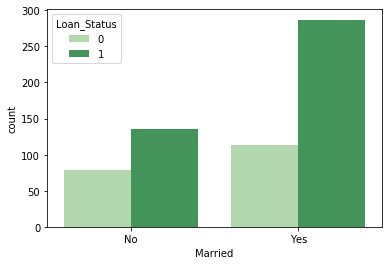

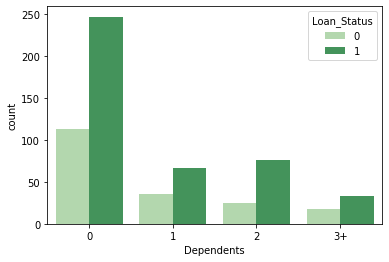

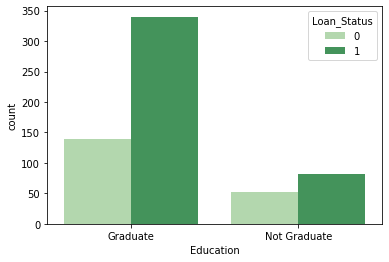

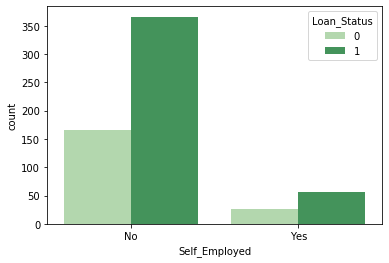

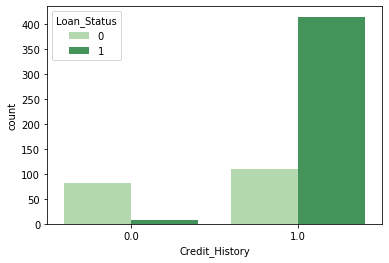

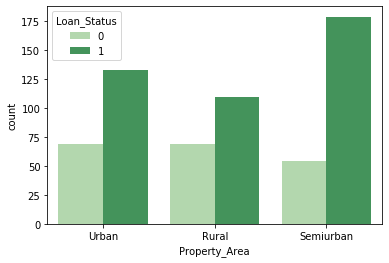

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

for features in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']:
    sns.countplot(x = features, hue = 'Loan_Status', data = Train, palette = 'Greens')
    
    plt.show()

Some interesting observations:
- There are much more male applicants than female, but the relative acceptance rate between them doesn't seem to differ by much.
- Married applicants are more likely to be accepted for loan applications.
- Applicants with no dependents are most likely to be accepted for loan applications. However, there are more accepted loans for applicants with 2 dependents, compared to 1.
- Graduates are more likely to be accepted for loan applications.
- It is much more difficult to get a loan accepted if you have no credit history.
- People living in semiurban area are most likely to be accepted for loan applications.

Let's take a look at the numerical features.

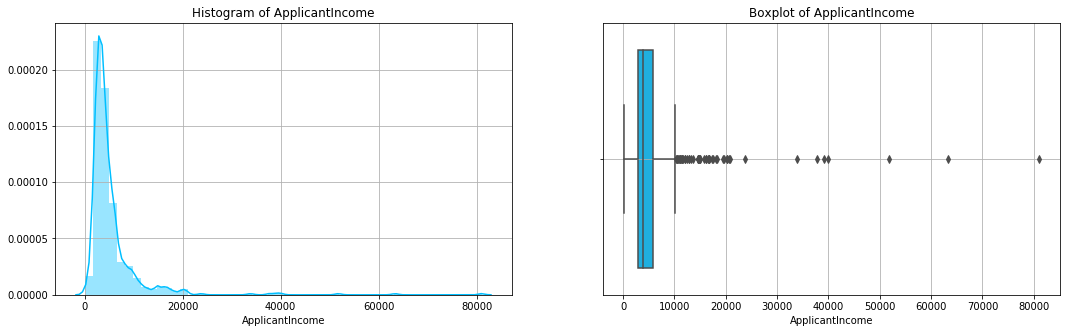

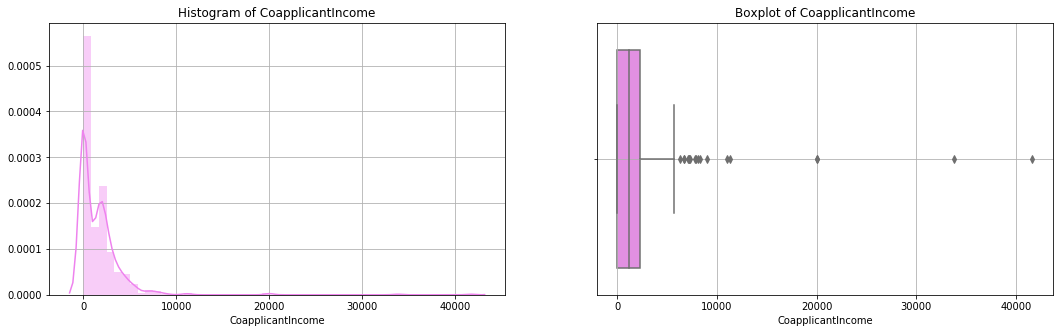

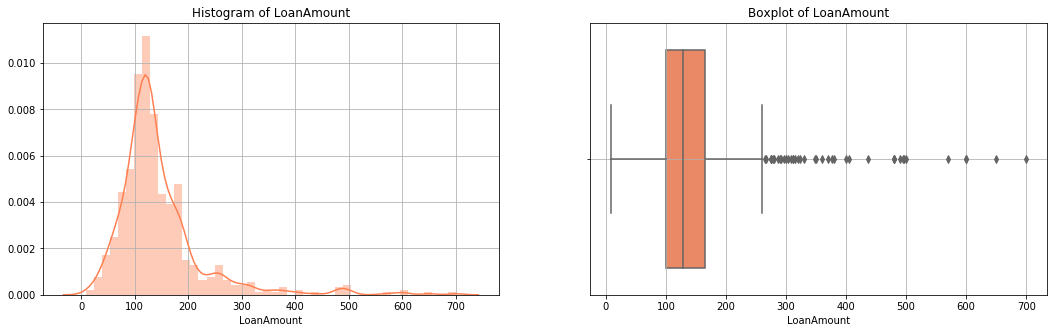

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['deepskyblue', 'violet', 'coral']

i = 0
for feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    
    fig = plt.figure(figsize = (18,5))
    
    ax = fig.add_subplot(1, 2, 1)
    sns.distplot(Train[feature], color = colors[i])
    plt.grid()
    plt.title('Histogram of {}'.format(feature))
    
    ax = fig.add_subplot(1,2,2)
    sns.boxplot(Train[feature], color = colors[i])
    plt.grid()
    plt.title('Boxplot of {}'.format(feature))
    
    i = i + 1
    
    plt.show()
    

<Figure size 720x1440 with 0 Axes>

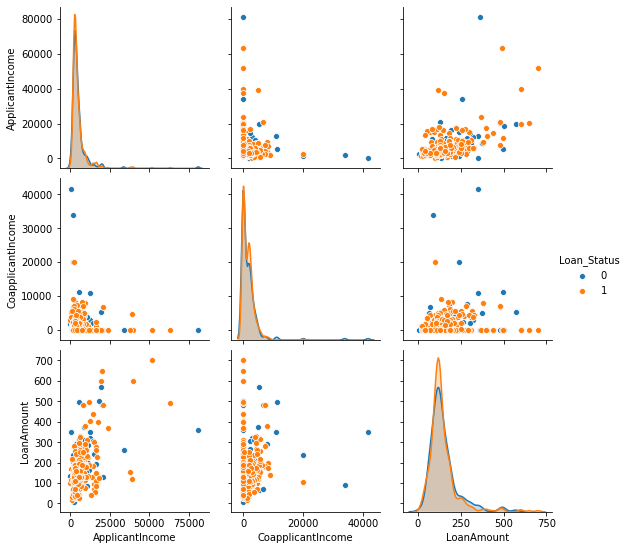

In [27]:
plt.figure(figsize = (10, 20))
sns.pairplot(Train, vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], hue = 'Loan_Status')
plt.show()

Perhaps, unsurprisingly, both the applicant's and coapplicant's monthly income are skewed, with much more applicants earning lower, and some earning much more, causing a long right tail in both distributions. Further, as the pairplot suggests a correlation between both income variables and the loan amount, we observe that the loan amount also follows a positively skewed distribution. 

These features, however, doesn't seem to contribute much to whether a loan should be accepted. We can see in these 3 features that there is a lot of overlap between good and bad loans.

Let's use some violinplots to try to get some more observations.

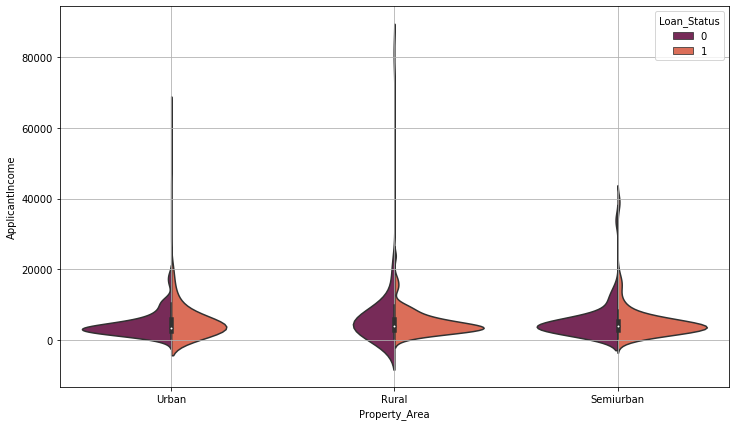

In [28]:
fig = plt.figure(figsize=(12, 7))
sns.violinplot(x = 'Property_Area', y = 'ApplicantIncome', hue = 'Loan_Status', 
               data = Train, split = True, palette = 'rocket')
plt.grid()
plt.show()

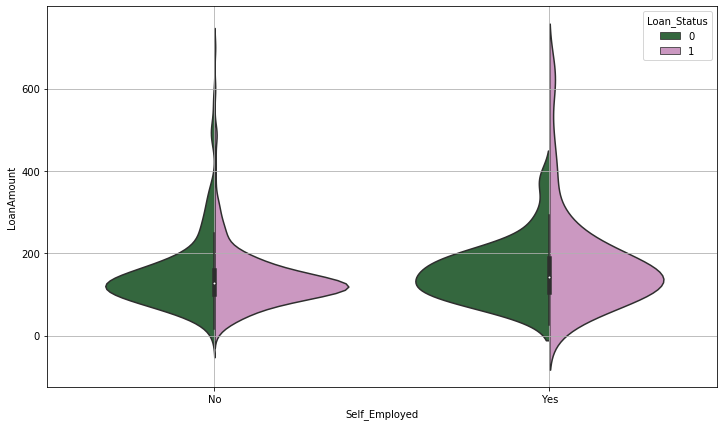

In [29]:
fig = plt.figure(figsize=(12, 7))
sns.violinplot(x = 'Self_Employed', y = 'LoanAmount', hue = 'Loan_Status', 
               data = Train, split = True, palette = 'cubehelix')
plt.grid()
plt.show()

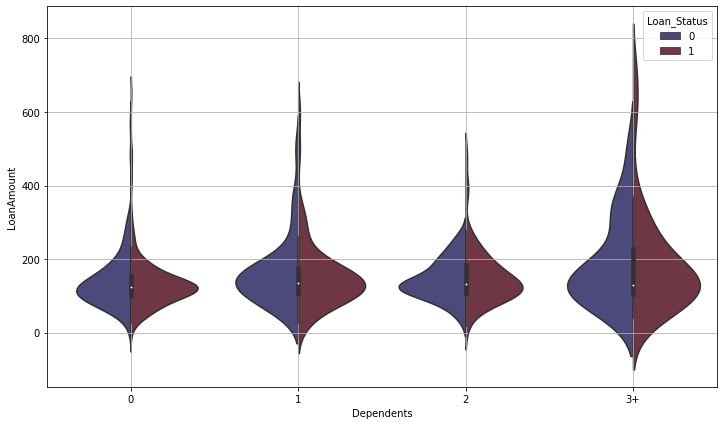

In [30]:
fig = plt.figure(figsize=(12, 7))
sns.violinplot(x = 'Dependents', y = 'LoanAmount', hue = 'Loan_Status', 
               data = Train, split = True, palette = 'icefire')
plt.grid()
plt.show()

Some further observations:
- On average, there is very little difference in the amount of loan applied for by applications living in rural, semiurban, or urban areas.
- There are relatively more self-employed applicants appplying for a bigger loan. Although again, the average loan size doesn't differ by much.


## Clustering

Now, we're going to try and use k-means to identify the different groups among the applicants. But first, we will need to prepare the data. 

In [31]:
y = Train['Loan_Status']
X = Train.drop('Loan_Status', axis = 1)

We'll encode the categorical variables.

In [32]:
for features in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    Dummies = pd.get_dummies(X[features], prefix = features)
    X = pd.concat([X, Dummies], axis = 1)
    
X.drop(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
               'Property_Area'], axis = 1, inplace = True)

and scale the numerical variables.

In [33]:
Min_list = []
Max_list = []

for features in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']:
    Min = X[features].min()
    Max = X[features].max()
    Min_list.append(Min)
    Max_list.append(Max)
    X[features] = (X[features] - Min)/(Max - Min)
    

In [34]:
X.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0.070489,0.000000,0.172214,0.74359,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1
1,0.054830,0.036192,0.172214,0.74359,1.0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0
2,0.035250,0.000000,0.082489,0.74359,1.0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1
3,0.030093,0.056592,0.160637,0.74359,1.0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
4,0.072356,0.000000,0.191027,0.74359,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1


Now, we can use k-means on the data.

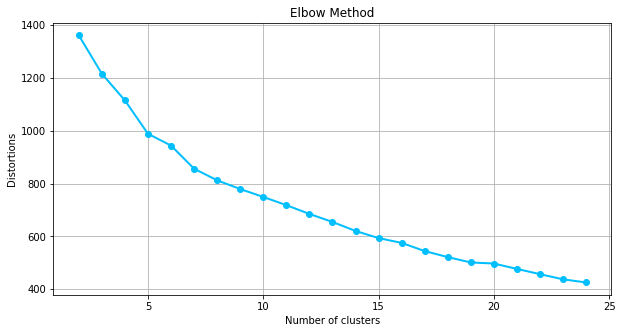

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []

for i in range(2,25):
    kmeans = KMeans(n_clusters = i, random_state = 5).fit(X)
    cluster_labels = kmeans.fit_predict(X)

    distortions.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.plot(np.arange(2,25), distortions, marker = 'o', lw = 2, color = 'deepskyblue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortions')
plt.grid()
plt.show()

As shown above, we perform the elbow method on our data. What this algorithm does is it runs k-means on the data (in this case between 2 and 50) and computes the distortion score, which is the sum of square distances from each point to its assigned center. 

What we're looking for is the inflection point. In this case, it seems that 5 or 6 might be a good point. We will check with the silhouette score.

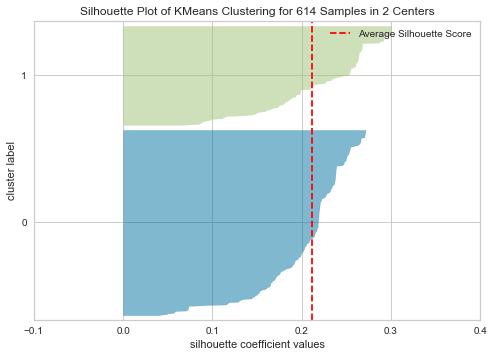

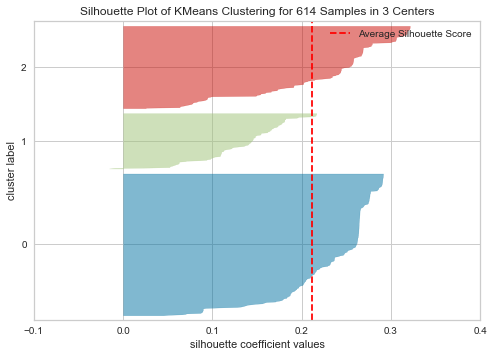

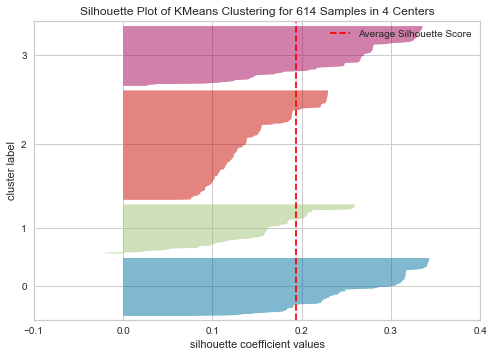

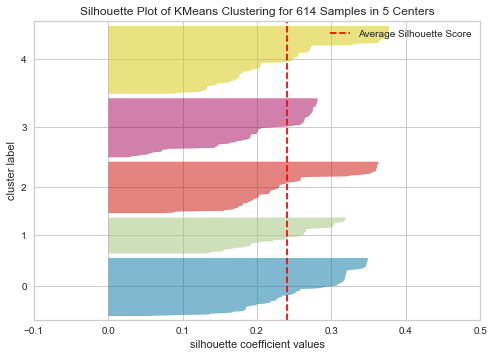

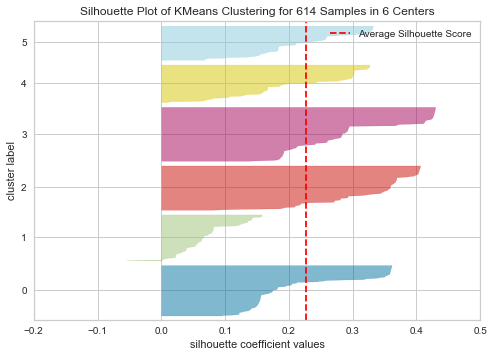

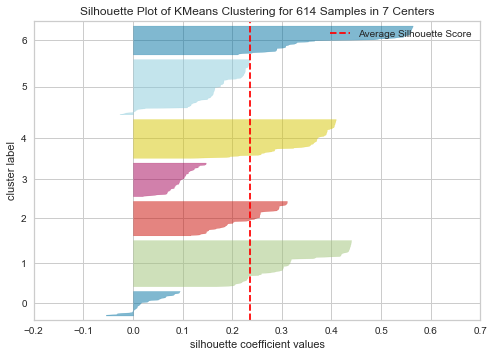

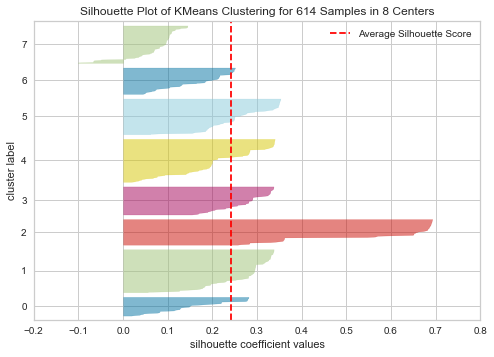

In [36]:
from yellowbrick.cluster import silhouette_visualizer

for i in [2,3,4,5,6,7,8]:
    kmeans = KMeans(n_clusters = i, random_state = 5)
    visualizer = silhouette_visualizer(kmeans, X, colors = 'yellowbrick')
    visualizer.show()

Using the silhouette method, it seems that 5 is the optimal value for k, since all the clusters are above the average silhouette score and they appear to be in quite similar sizes.

Thus, we will continue with k = 5.

In [37]:
kmeans = KMeans(n_clusters = 5, random_state = 5)
clusters_5 = kmeans.fit_predict(X)

X['Cluster'] = clusters_5
Train['Cluster'] = clusters_5

In [38]:
Train['Cluster'].value_counts()

4    153
3    133
0    131
2    116
1     81
Name: Cluster, dtype: int64

We see that there is a quite a balanced number of entries in each cluster, which is good.

Now, let's see if there are any differences in loan eligibility between these clusters.

In [39]:
Train.groupby('Cluster').mean()['Loan_Status']

Cluster
0    0.702290
1    0.629630
2    0.620690
3    0.631579
4    0.803922
Name: Loan_Status, dtype: float64

And it appears that there is a clear distinction, where cluster 4 is the group with the highest loan eligibility rate. This would mean that the customers with similar characteristics to this cluster should be the focus in a marketing campaign. 

Further, cluster 0 is the 2nd best cluster, although there is quite a drop in the eligibility rate. The 3 other clusters have similar value, with cluster 3 being the worst. It only has a 62% eligibility rate, which means that around 38% of the applications in this cluster could lead to bad loans.

Now, let us explore the characteristics of cluster 4.

In [40]:
Best_cluster = Train[Train['Cluster'] == 4]

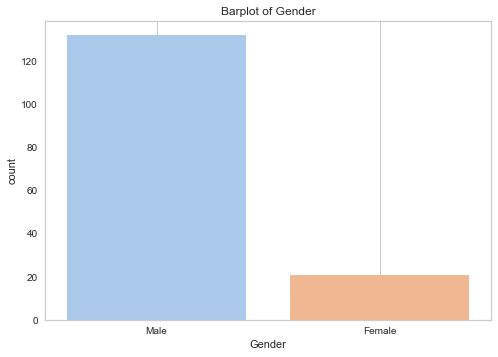

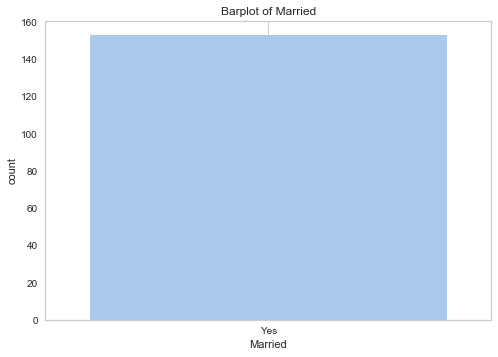

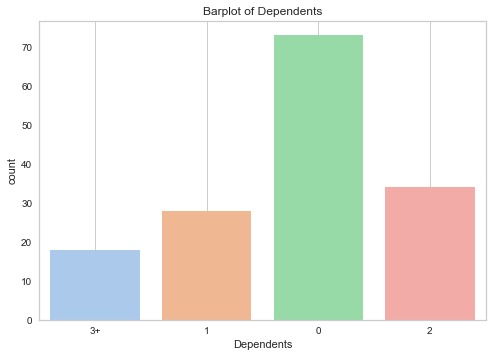

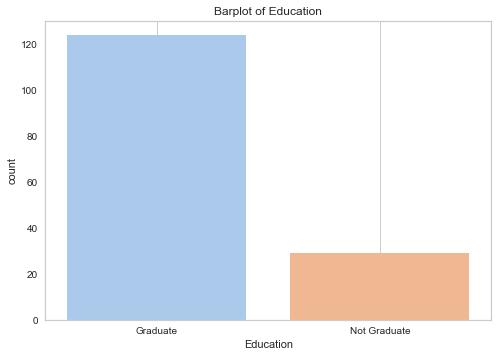

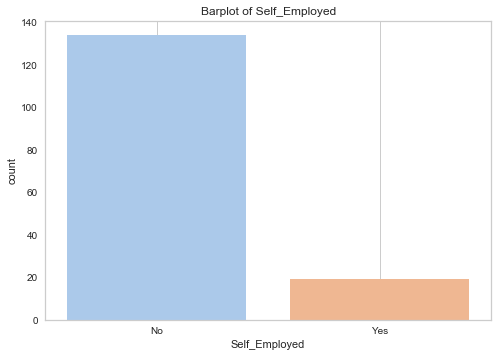

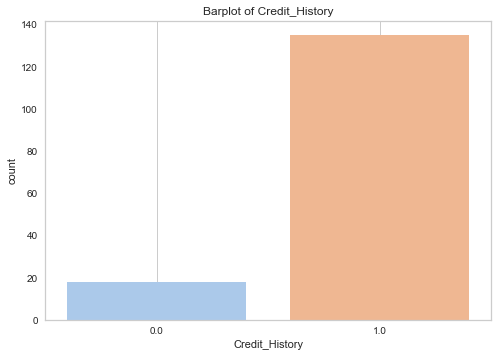

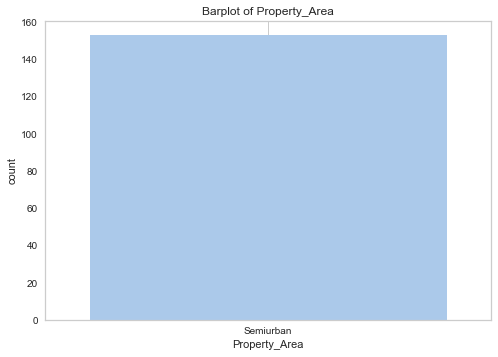

In [41]:
cats = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

for features in cats:    
    sns.countplot(x = features, data = Best_cluster, palette = 'pastel')
    plt.title('Barplot of {}'.format(features))
    plt.grid()
    plt.show()

Now, let's take a look at the other clusters.

In [42]:
Cluster0 = Train[Train['Cluster'] == 0]
Cluster1 = Train[Train['Cluster'] == 1]
Cluster2 = Train[Train['Cluster'] == 2]
Cluster3 = Train[Train['Cluster'] == 3]

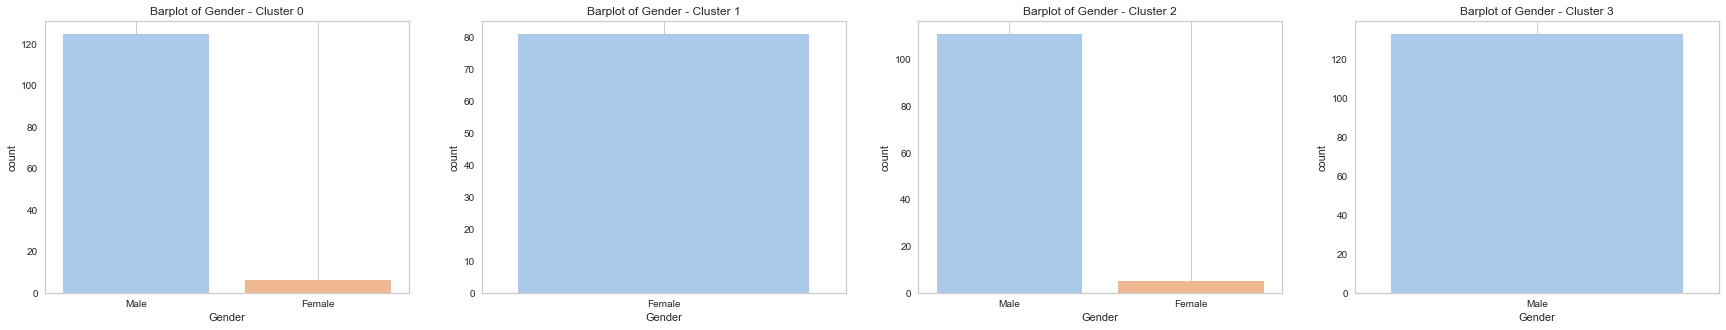

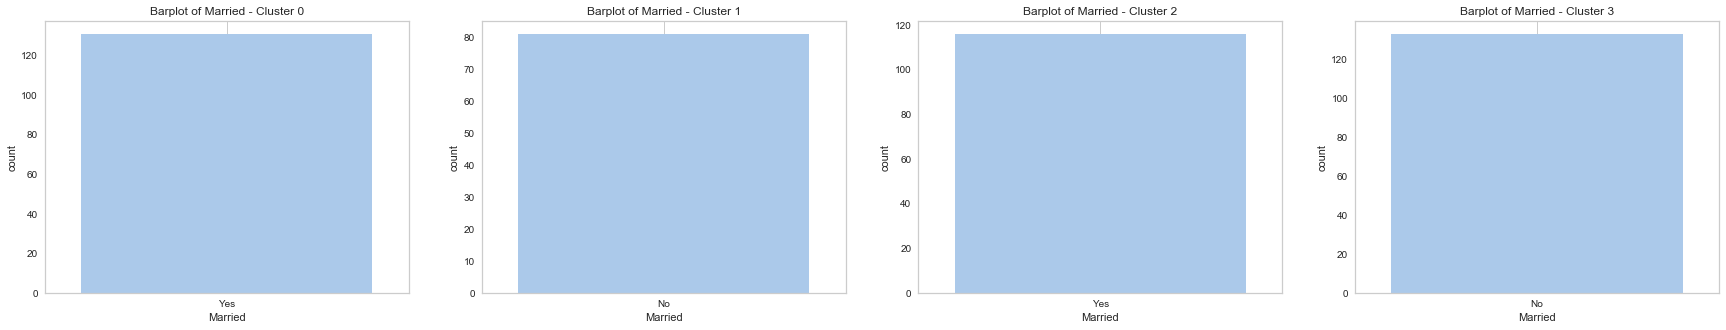

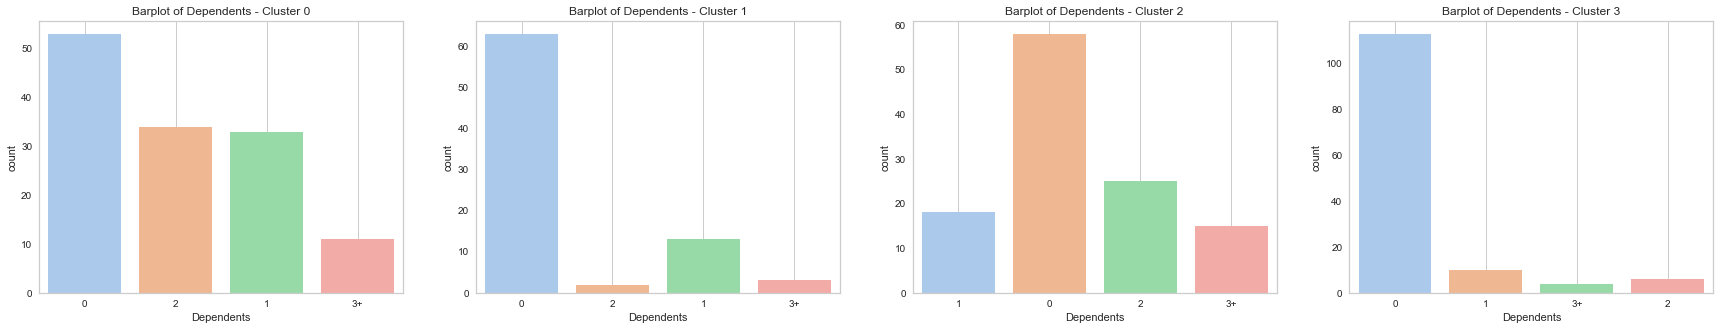

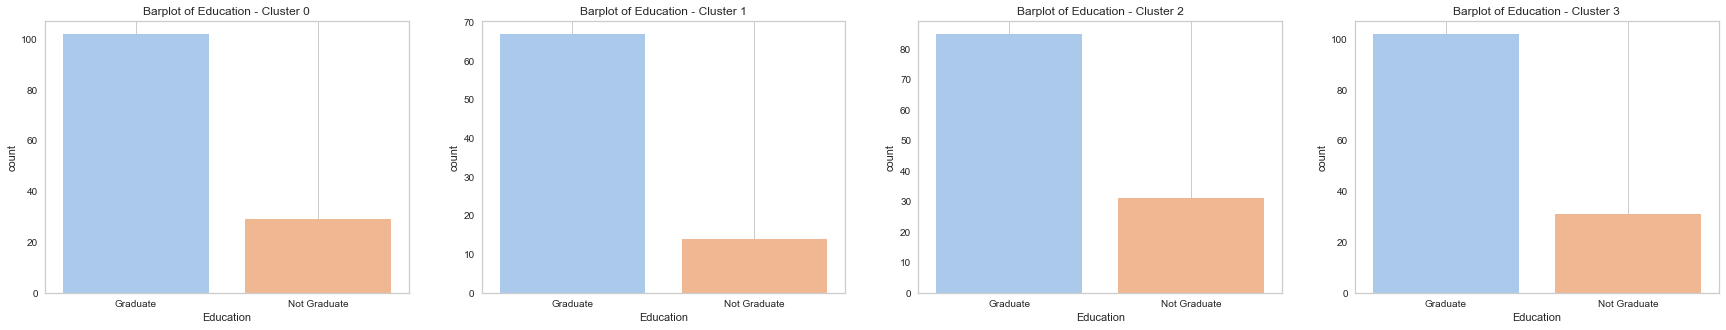

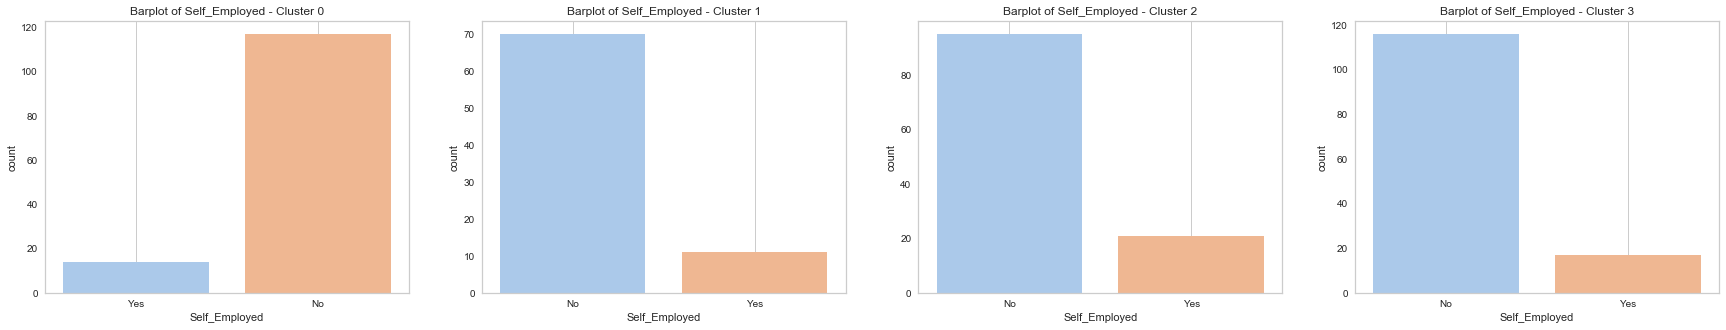

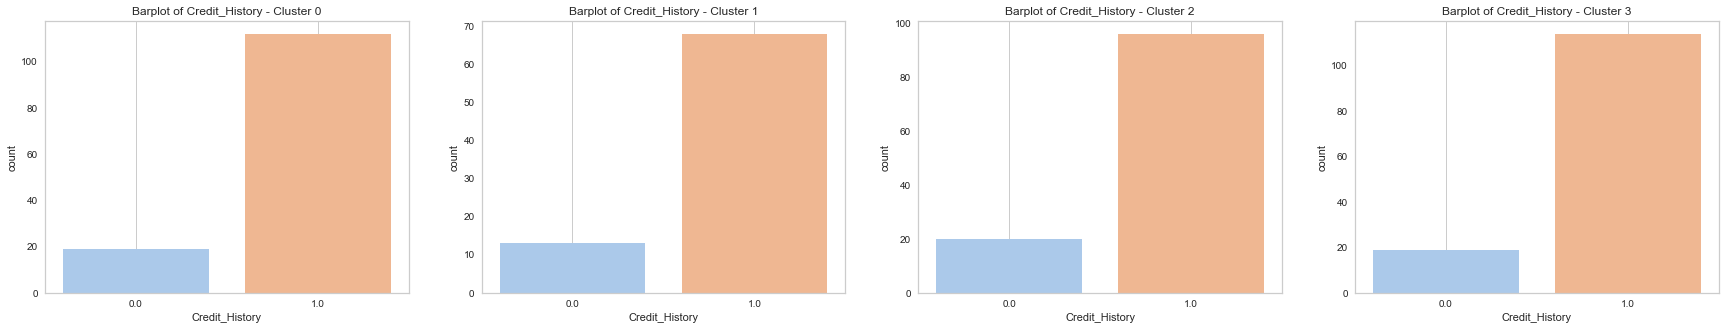

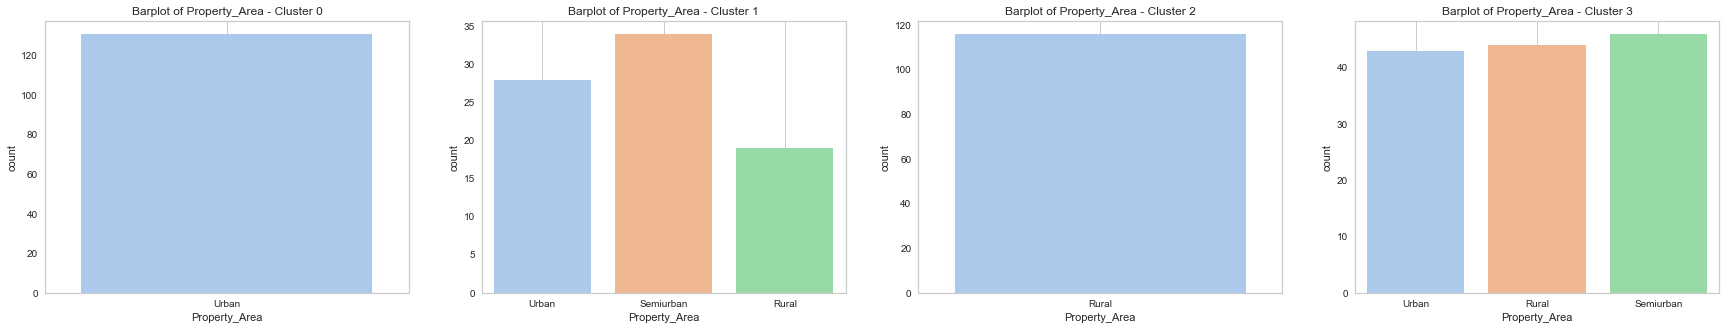

In [44]:
cats = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

for features in cats:
    fig = plt.figure(figsize = (30,5))
    
    ax = fig.add_subplot(1, 4, 1)
    sns.countplot(x = features, data = Cluster0, palette = 'pastel')
    plt.title('Barplot of {} - Cluster 0'.format(features))
    plt.grid()
    
    ax = fig.add_subplot(1, 4, 2)
    sns.countplot(x = features, data = Cluster1, palette = 'pastel')
    plt.title('Barplot of {} - Cluster 1'.format(features))
    plt.grid()
    
    ax = fig.add_subplot(1, 4, 3)
    sns.countplot(x = features, data = Cluster2, palette = 'pastel')
    plt.title('Barplot of {} - Cluster 2'.format(features))
    plt.grid()
    
    ax = fig.add_subplot(1, 4, 4)
    sns.countplot(x = features, data = Cluster3, palette = 'pastel')
    plt.title('Barplot of {} - Cluster 3'.format(features))
    plt.grid()
    
    plt.show()

Based on the observations from the clusters above, we can conclude that married applicants with properties in semiurban/ urban areas are the best loan applicants, and that a home loan marketing campaign should be focused on them. 

In our analysis, we didn't focus on the numerical features as they do not seem to contribute much to whether a loan should be accepted. To confirm this, we look at the following plots.

In [45]:
from mpl_toolkits.mplot3d import Axes3D

<function matplotlib.pyplot.show(*args, **kw)>

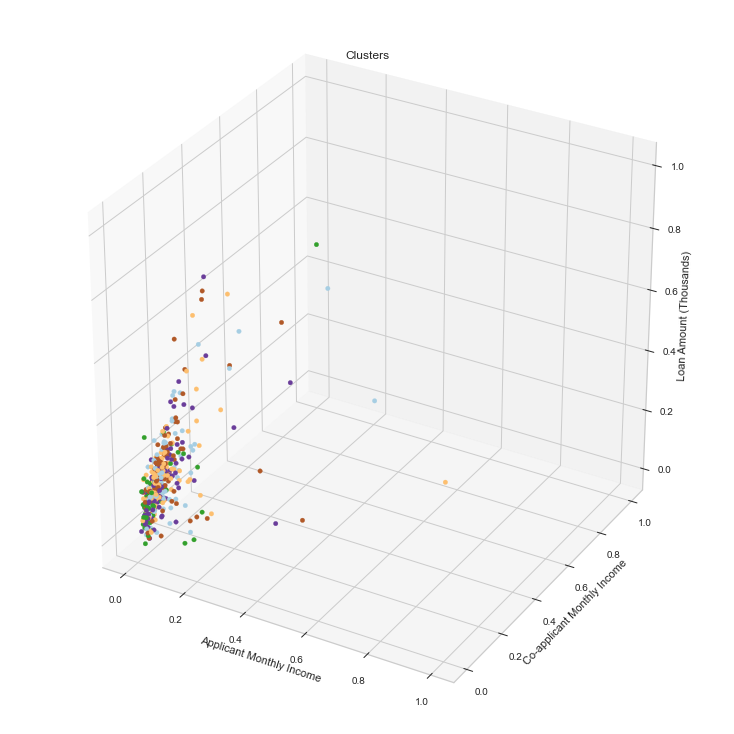

In [46]:
fig = plt.figure(figsize=(10, 10))

ax = Axes3D(fig)

ax.scatter(X['ApplicantIncome'], X['CoapplicantIncome'], X['LoanAmount'], 
           c = X['Cluster'], marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('Applicant Monthly Income')
ax.set_ylabel('Co-applicant Monthly Income')
ax.set_zlabel('Loan Amount (Thousands)')
plt.title('Clusters')
plt.show

And a zoomed-in version.

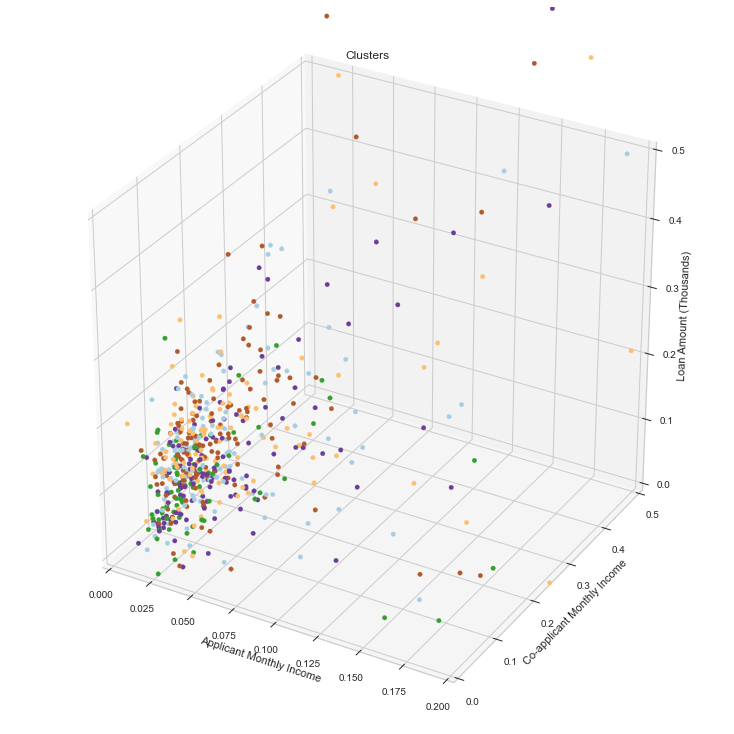

In [47]:
fig = plt.figure(figsize=(10, 10))

ax = Axes3D(fig)

ax.scatter(X['ApplicantIncome'], X['CoapplicantIncome'], X['LoanAmount'], 
           c = X['Cluster'], marker='o', depthshade=False, cmap='Paired')
ax.set_xlabel('Applicant Monthly Income')
ax.set_ylabel('Co-applicant Monthly Income')
ax.set_zlabel('Loan Amount (Thousands)')

plt.xlim(0, 0.2)
plt.ylim(0, 0.5)
ax.set_zlim(0, 0.5)
plt.title('Clusters')
plt.show()

We can see that the clusters are overlapping with each other, when plotted only with the numerical features. This confirms that the numerical features don't really contribute to the loan status.

## Conclusion

As a conclusion, if the firm would like to launch a home loan marketing campaign, they should focus on advertising it to married people living in either the semiurban and urban areas as these characteristics were found to be among the groups resulting in more good loans.